In [1]:
%matplotlib inline
import itertools
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import scipy
import scipy.io
import warnings
from scipy import signal      

warnings.filterwarnings("ignore")

In [141]:
import os
from scipy.io import loadmat
from utilities  import plot_model

DATASET_PATH_ = "/home/oem/Desktop/KernelizedDynamicalSystems" + "/resources/DataSet"

NAMES_ = [f[:-4] for f in os.listdir(DATASET_PATH_) if f[-4:] == ".mat"]

if os.path.isdir(DATASET_PATH_):
    print ("Using LASA DataSet from {}".format(DATASET_PATH_))
else:
    raise IOError("Could not find LASA Dataset in path: {}".format(DATASET_PATH_))

class _Demo(object):
    """
        Each demo object has attributes:

        pos : 2D cartesian position data. shape: (2,1000)
        t   : corresponding time for each data point. shape: (1,1000)
        vel : 2D cartesian velocity data for motion. shape: (2,1000)
        acc : 2D cartesian acceleration data for motion. shape: (2,1000)

    """
    def __init__(self, demo):


        typelist = str(np.asarray(demo[0][0].dtype))
        typelist = typelist[1:-2].split(', ')
        idx = 0
        for att in typelist:
            if "'O'" in att:
                continue
            else:
                setattr(self, att[2:-1], demo[0][0][idx])
                idx+=1

        assert idx == 5, "Reading data for demo failed"

class _Data(object):
    """
        Data object for each pattern has the following two attributes:

        dt : the average time steps across all demonstrations for this pattern
        demos : array of _Demo objects (len: 7) corresponding the trials for this pattern

    """
    def __init__(self, matdata, name):
        self.name = name
        self.dt = matdata['dt'][0][0]
        self.demos = [_Demo(d) for d in matdata['demos'][0]]

        assert len(self.demos) == 7, "ERROR: Data for matdata could not be read properly."

    def __repr__(self):
        return str({'dt':self.dt, 'demos':self.demos})

    @classmethod
    def get_data(cls, name):
        return cls(loadmat("{}/{}.mat".format(DATASET_PATH_,name)), name)


class _PyLasaDataSet(object):

    def __getattr__(self, name):
        if name in NAMES_:
            return _Data.get_data(name)
        else:
            raise AttributeError("DataSet has no data named '{}'".format(name))


DataSet = _PyLasaDataSet()

Using LASA DataSet from /home/oem/Desktop/KernelizedDynamicalSystems/resources/DataSet


In [276]:
class SIMPLe():
    
    def __init__(self):
        
        self.rec_freq=100
        self.weigth_time=2
        self.index=0
        self.DataSet=_PyLasaDataSet()
        
    def load(self, path='/home/oem/Desktop/KernelizedDynamicalSystems/robInfLib-matlab/2Dletters/O.mat'):
        
        X_demo= scipy.io.loadmat(path)
        self.traj=np.zeros([2,200])
        for j in range(0,200):
            self.traj[0,j]=(X_demo['demos'][0,0][0][0][0][0][j]-X_demo['demos'][0,0][0][0][0][0][-1])/10
            self.traj[1,j]=(X_demo['demos'][0,0][0][0][0][1][j]-X_demo['demos'][0,0][0][0][0][1][-1])/10
            
     
    def load_lasa(self, shape='GShape'):
        self.shape=shape
        angle_data = getattr(self.DataSet, shape)
        demos = angle_data.demos 
        next_point=10
        X_tot=(demos[0].pos[:,100::1])
        Y_tot=np.zeros((2,np.size(X_tot,1)))
        
        for j in range(np.size(X_tot,1)-next_point): 
            Y_tot[:,j]=X_tot[:,j+next_point]
            
        
        X_tot=np.transpose(X_tot)
        Y_tot=np.transpose(Y_tot)
        
        downsample=10
        
        
        self.X=np.vstack([X_tot[::downsample,:],X_tot[-1,:]])
        self.Y=np.vstack([Y_tot[::downsample,:],Y_tot[-1,:]])
        self.traj=np.transpose((X_tot[0::downsample,:]))
        
    def plot_traj(self):
        plt.scatter(self.traj[0,:],self.traj[1,:], color=[1,0,0])
        plt.show()
        
        
    def execute(self):
        
        time_weight=self.rec_freq*self.weigth_time
        traj_error = np.linalg.norm(self.traj.T - np.array(self.cart_pos), axis=1)
         
        if self.index is not(None):    
            index_error= np.abs(np.arange(self.traj.shape[1])-self.index)/time_weight
            traj_error_total=traj_error+index_error
        else:
            traj_error_total=traj_error
        
        min_traj_error=np.min(traj_error)
        
        if np.min(min_traj_error) > 0.1: 
            beta= np.exp(-(min_traj_error-0.1)/0.1)
        else:
            beta=1
            
        i_belief = np.min([int(np.argmin(traj_error_total))+1, self.traj.shape[1]-1])

        attractor_pos = np.array(self.cart_pos)+ np.clip(np.array([self.traj[0][i_belief], self.traj[1][i_belief]])-np.array(self.cart_pos),-0.1,0.1)
        
        
        return  attractor_pos, i_belief, beta
    
    def rollout(self, ind, x, steps):
        
        if ind is not(None):
            self.index=ind
        else:
            self.index=None
        self.cart_pos=np.array([x[0],x[1]]).reshape(1,-1)
        self.traj_rollout=np.zeros((2,steps))
        self.traj_rollout[:,0]=x
        
        for i in range(steps-1):
            [attractor_pos, i_belief, beta]=self.execute()
            #self.index=ind
            if  ind is None:
                self.index=None
            else:
                self.index=i_belief         
            self.cart_pos=attractor_pos+ 0.01 * np.random.randn(1,2)
            self.traj_rollout[:,i+1]= self.cart_pos
        self.traj_rollout=scipy.signal.savgol_filter(self.traj_rollout,11, polyorder=3)
        
    def plot_stream(self,i=None):
        self.index=i
        x=np.linspace(np.min(self.traj[0,:])-0.2, np.max(self.traj[0,:])+0.2, 300)
        y=np.linspace(np.min(self.traj[1,:])-0.2, np.max(self.traj[1,:])+0.2, 300)
        u=np.ones((len(x),len(y)))
        v=np.ones((len(x),len(y)))
        BETA=np.ones((len(x),len(y)))
        XX, YY = np.meshgrid(x, y)
        for i in range(len(y)):
            for j in range(len(x)):
                self.cart_pos=np.array([XX[i,j],YY[i, j]]).reshape(1,-1)

                [attractor, i_belief, beta]= self.execute()

                u[i,j]=np.clip(attractor[0][0]-self.cart_pos[0][0],-0.1,0.1) #0.1
                v[i,j]=np.clip(attractor[0][1]-self.cart_pos[0][1],-0.1,0.1) #0.1
                BETA[i,j]=beta
                
                
        plt.scatter(self.traj[0,:],self.traj[1,:], color=[1,0,0])
        if self.index is not(None):
            plt.scatter(self.traj[0,self.index],self.traj[1,self.index], marker="*", color=[0,1,0], linewidths=2)
        domain = np.identity(3)
        u=scipy.signal.medfilt2d(u,kernel_size=11)
        v=scipy.signal.medfilt2d(v,kernel_size=11)
        plt.streamplot(XX, YY, u, v, density = 2, color=[0,0,0])
        plt.savefig("/home/oem/Desktop/SIMPLe" + "/figures/"+"figure.png" , dpi=300)
        plt.show()
        
        
SIMPLe=SIMPLe()

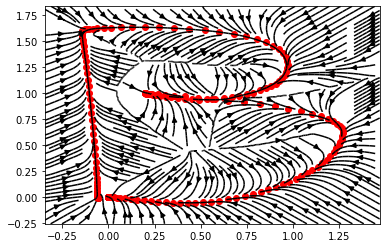

In [177]:
SIMPLe.load(path='/home/oem/Desktop/KernelizedDynamicalSystems/robInfLib-matlab/2Dletters/B.mat')
# SIMPLe.plot_stream(10)
# SIMPLe.plot_stream(i=88)
# SIMPLe.plot_stream(i=100)
# SIMPLe.plot_stream(i=107)
# SIMPLe.plot_stream(i=115)
# SIMPLe.plot_stream(i=199)
SIMPLe.plot_stream()

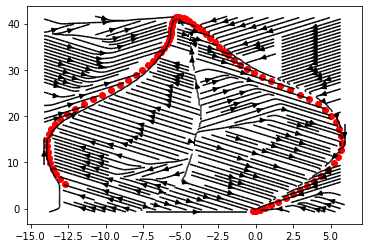

In [174]:
SIMPLe.load_lasa(shape='Leaf_1')
SIMPLe.plot_stream()

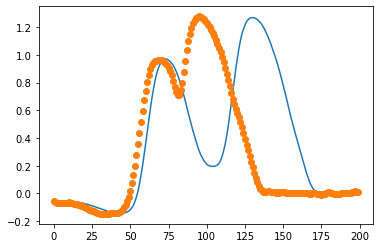

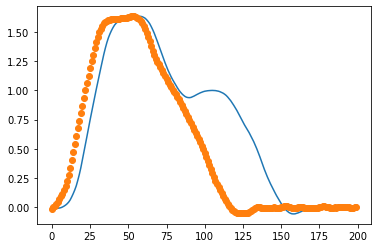

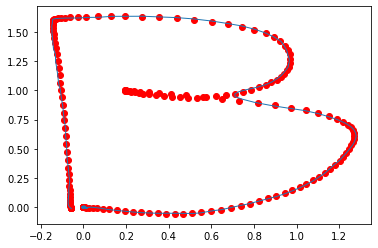

In [277]:
# SIMPLe=SIMPLe()
SIMPLe.load(path='/home/oem/Desktop/KernelizedDynamicalSystems/robInfLib-matlab/2Dletters/B.mat')
ind=None
SIMPLe.rollout(ind, SIMPLe.traj[:,0], 200)
plt.plot(SIMPLe.traj[0,:])
plt.plot(SIMPLe.traj_rollout[0,:], 'o')
plt.show()
plt.plot(SIMPLe.traj[1,:])
plt.plot(SIMPLe.traj_rollout[1,:], 'o')
plt.show()
plt.plot(SIMPLe.traj[0,:],SIMPLe.traj[1,:],'o', color=[1,0,0])
plt.plot(SIMPLe.traj_rollout[0,:],SIMPLe.traj_rollout[1,:], linewidth=1)
plt.show()

In [313]:
# SIMPLe=SIMPLe()
SIMPLe.load(path='/home/oem/Desktop/KernelizedDynamicalSystems/robInfLib-matlab/2Dletters/B.mat')
n_rollouts=200
TRAJ_x=np.zeros([n_rollouts,200])
TRAJ_y=np.zeros([n_rollouts,200])
for j in range(n_rollouts):
    ind=None
    SIMPLe.rollout(ind, SIMPLe.traj[:,0], 200)
    TRAJ_x[j,:]=SIMPLe.traj_rollout[0,:]
    TRAJ_y[j,:]=SIMPLe.traj_rollout[1,:]

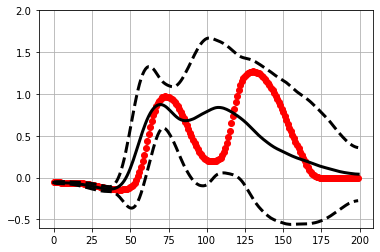

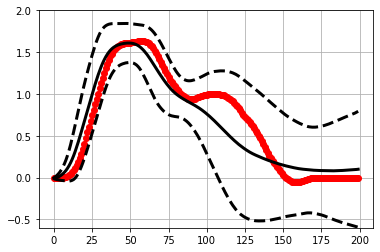

In [314]:
plt.plot(SIMPLe.traj[0,:], 'o', color='red')
plt.plot(np.mean(TRAJ_x,0), linewidth=3, color='black')
plt.plot(np.mean(TRAJ_x,0)+2*np.std(TRAJ_x,0), '--',linewidth=3, color='black')
plt.plot(np.mean(TRAJ_x,0)-2*np.std(TRAJ_x,0), '--',linewidth=3, color='black')
plt.grid()
# plt.xlabel('time_index')
plt.ylim([-0.6,2])
plt.savefig("/home/oem/Desktop/SIMPLe" + "/figures/"+"figure_x.png" , dpi=300)
plt.show()

plt.plot(SIMPLe.traj[1,:], 'o', color='red')
plt.plot(np.mean(TRAJ_y,0), linewidth=3, color='black')
plt.plot(np.mean(TRAJ_y,0)+2*np.std(TRAJ_y,0), '--',linewidth=3, color='black')
plt.plot(np.mean(TRAJ_y,0)-2*np.std(TRAJ_y,0), '--',linewidth=3, color='black')
plt.grid()
# plt.xlabel('time_index')
# plt.title('y axis')
plt.ylim([-0.6,2])
plt.savefig("/home/oem/Desktop/SIMPLe" + "/figures/"+"figure_y.png" , dpi=300)
plt.show()

# plt.plot(SIMPLe.traj[0,:],SIMPLe.traj[1,:],'o', color=[1,0,0])
# plt.plot(np.mean(TRAJ_x,0),np.mean(TRAJ_y,0), linewidth=1)
# plt.plot(np.mean(TRAJ_x,0)+2*np.std(TRAJ_x,0),np.mean(TRAJ_y,0)+2*np.std(TRAJ_y,0), linewidth=1)
# plt.plot(np.mean(TRAJ_x,0)-2*np.std(TRAJ_x,0),np.mean(TRAJ_y,0)-2*np.std(TRAJ_y,0), linewidth=1)
# plt.show()

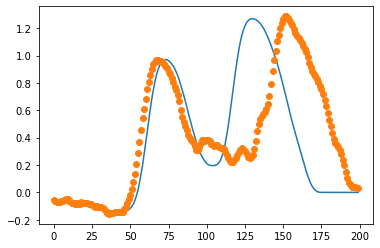

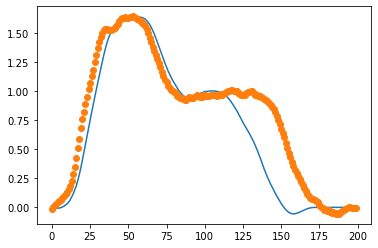

In [188]:
plt.plot(SIMPLe.traj[0,:])
plt.plot(SIMPLe.traj_rollout[0,:], 'o')
plt.show()
plt.plot(SIMPLe.traj[1,:])
plt.plot(SIMPLe.traj_rollout[1,:], 'o')

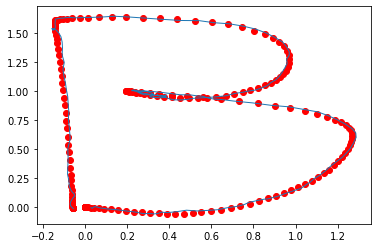

In [189]:
plt.plot(SIMPLe.traj[0,:],SIMPLe.traj[1,:],'o', color=[1,0,0])
plt.plot(SIMPLe.traj_rollout[0,:],SIMPLe.traj_rollout[1,:], linewidth=1)
plt.show()